# P-POIS Optimization test
In this notebook we will build an optimization procedure for an agent that has the goal of keeping the Como Lake at a constant level. The inflow values that will be used start in 1946 and ends in 2011. More recent values can be found at this [link](https://adda.laghi.net/homepage.aspx?tab=3&subtab=2&idlago=1).

In [1]:
# 'autoreload' allows to update modules without resetting the kernel 
%load_ext autoreload
%autoreload 2

# Import stuff
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import os

## Como Lake RL Environment
We start by building the environment of the lake, which at each timestep will be represented by its water level (which will be the state $s_t$ and by the inflow $i_t$ of that day. In particular, the agent will choose its action $a_t$ knowing the current level of the lake but not the inflow that will be measured during that day. The reward $r_t$ will simply be equal the difference between the current level and the zero-level $s_0=197.37m$ of the Comolake.

The update of the state is given by the following equation:

$$ s_{t+1} = s_t + \frac{(~\text{inflow}_t - \text{outflow}_t~)~n_{\text{sec}}}{\text{Area}} $$

where $s$ represents the daily level of the lake (measured in $m$), $\text{inflow}$ and $\text{outflow}$ are the averaged values (measured in $m^3/s$) for their corresponding day, $n_\text{sec}$ is the number of seconds in a day and $\text{Area}$ represents the surface area of the lake. For the moment I found $\text{Area}=146km^2$, but a more accurate value should be needed.

In [2]:
class como_lake:
    
    
    def __init__(self, s0=197.37, t0=0, zero_state=197.37, inflows=None):
        
        # Define initial and objective levels of water
        self.state = s0
        self.zero_state = zero_state
        
        # If there are not custom inflow values, take historic data
        if inflows == None:
            self.inflows = np.genfromtxt('data/como_data_1946_2011.txt', delimiter="  ")[1:,5]
        self.t_limit = len(self.inflows)
        self.time = t0     
        
        
        
    def step(self, outflow, inflow=None):
        
        ### Given the outflow (action), this function updates the state by 
        ### subtractingthe outflow and adding the inflow of the corresponding
        ### day. It also computes the reward as the absolute distance from 
        ### the zero level
        ###
        ### Output: reward, end_flag 
        
        # Take inflow value from data if not provided
        if inflow == None:
            inflow = self.inflows[self.time]
        
        # Check if:  - Outflow is positive -> if negative, consider it equal to 0
        #            - There is enough water to release -> if not, clip it to the current level
        outflow = np.clip(outflow, 0, self.state*146000000/86400)
        
        # Compute new level of the lake after action and inflow
        in_out_diff = self.inflows[self.time] - outflow
        self.state += in_out_diff*86400 / 146000000
        
        # Check if there still is inflow data: if yes, update time index
        if self.time >= self.t_limit:
            return -np.abs(self.state-self.zero_state), True
        else:
            self.time += 1
            return -np.abs(self.state-self.zero_state), False
    
    
    
    def play(self, nu, n_steps, optimize=True):
        
        ### This function uses the hyperpolicy nu to perform many subsequent 
        ### steps. Returns the evolution of many variables
        
        # Prepare arrays to store states and rewards
        states   = np.array([self.state])
        actions  = np.array([])
        rewards  = np.array([])
        nu_means = np.array([[nu.W_mean(self.time),nu.b_mean(self.time)]])
        thetas   = np.array([]).reshape(0,2)
        
        # At each timestep..
        for t in range(n_steps):
            
            # Sample a policy from the hyperpolicy
            policy = nu.sample_policy(self.time)
            
            # Perform a step sampling the action from current policy 
            action = policy.action(self.state)
            reward, _ = self.step(action)
            
            # Optimize hyperpolicy if flag is 'True'
            if optimize:
                
                # DEFINE OPTIMIZATION PROCEDURE
                print('TO DO')
                
            
            # Store current values in the arrays
            states  = np.append(states, self.state)
            actions = np.append(actions, action)
            rewards = np.append(rewards, reward)
            nu_means = np.append(nu_means, [[nu.W_mean(self.time),nu.b_mean(self.time)]], axis=0)
            thetas = np.append(thetas, [policy.params()], axis=0)
            
        return states, actions, rewards, nu_means, thetas
        

## Hyper-Policy and Policies
The policy is linear and deterministic, thus we have $a = \pi_{\theta_t}(s) = W_t s + b_t$ and $\theta_t=\{W_t,b_t\}$, but we will clip it to $0$ if it tries to release a negative quantity of water. Then, the hyper-policy will be $\nu_\rho(W_t,b_t|t) = \left( \mathcal{N}(\mu_{W,t},\Sigma_{W,t}), \mathcal{N}(\mu_{b,t},\Sigma_{b,t}) \right)$, with:
 - $\mu_{W,t} = \nu_{\rho,W}(t) = A_{W} \sin(\phi_{W} t + \psi_{W}) + B_{W}$
 - $\mu_{b,t} = \nu_{\rho,b}(t) = A_{b} \sin(\phi_{b} t + \psi_{b}) + B_{b}$
 - $\Sigma_{W,t}$ and $\Sigma_{b,t}$ given as parameters

In [3]:
class linear_policy:
    
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
    def params(self):
        return self.W, self.b
        
    def action(self, state):
        return self.W*state + self.b

In [4]:
class hyperpolicy:
        
    def __init__(self, sigma_W=1, sigma_b=1, params=None):
        
        # Store sigmas of the gaussian distributions
        self.sigma_W = sigma_W
        self.sigma_b = sigma_b
        
        # If params are given, initialize hyperpolicy means with them, else take random ones
        if params == None:
            params = np.random.rand(8)
            
        self.A_w   = params[0]
        self.B_w   = params[1]
        self.phi_w = params[2]
        self.psi_w = params[3]
        
        self.A_b   = params[4]
        self.B_b   = params[5]
        self.phi_b = params[6]
        self.psi_b = params[7]

        
    def params(self):
        return [self.A_w, self.B_w, self.phi_w, self.psi_w,
                self.A_b, self.B_b, self.phi_b, self.psi_b]
    
    
    
    def W_mean(self, t):
        return self.A_w * np.sin(self.phi_w*t + self.psi_w) + self.B_w
    
    def b_mean(self, t):
        return self.A_b * np.sin(self.phi_b*t + self.psi_b) + self.B_b
    
    def W_pdf(self, W, t):
        return scipy.stats.norm.pdf(W, loc=self.W_mean(t), scale=self.sigma_W)
    
    def b_pdf(self, b, t):
        return scipy.stats.norm.pdf(b, loc=self.b_mean(t), scale=self.sigma_b)
    
    def theta_pdf(self, theta, t):
        return self.W_pdf(theta[0],t) * self.b_pdf(theta[1],t)
    
    
    def sample_theta(self, t):
        W = scipy.stats.norm.rvs(loc=self.W_mean(t), scale=self.sigma_W)
        b = scipy.stats.norm.rvs(loc=self.b_mean(t), scale=self.sigma_b)
        return W, b

    def sample_policy(self, t):
        W, b = self.sample_theta(t)
        return linear_policy(W,b)
    
    
    #def update_params(self, delta_params):
        
        # TO DO
        

## Metrics and Tools
Here we define three possible performance estimators of our hyperpolicy $\nu_{\rho'}$ on the last $\alpha$ samples collected by a behavioural hyperpolicy $\nu_\rho$. They are defined in the `performance_estimators.py` file and are:

 - Trajectory return estimation (IS weight based on entire trajectory):
   $$ J^1_t(\nu_\rho) = \left( \prod_{i=t-\alpha}^{t}  \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)} \right) \left(\sum_{i=t-\alpha}^{t} \beta^{t-i} \gamma^{i-t+\alpha} R(s_i,\pi_{\theta_i}(s_i))\right) $$
 - Per-step reward estimation (IS weight based on trajectory up to time $i$):
   $$ J^2_t(\nu_\rho) =  \sum_{i=t-\alpha}^{t} \beta^{t-i} \gamma^{i-t+\alpha} R(s_i,\pi_{\theta_i}(s_i))\left( \prod_{k=t-\alpha}^{i} \frac{\nu_\rho(\theta_k\vert t+1)}{\nu_\rho(\theta_k\vert k)} \right) $$
 - Per-step reward estimation (IS weight based only on $i$-th timestep):
   $$ J^3_t(\nu_\rho) =  \sum_{i=t-\alpha}^{t} \beta^{t-i} \gamma^{i-t+\alpha} R(s_i,\pi_{\theta_i}(s_i)) \frac{\nu_\rho(\theta_i\vert t+1)}{\nu_\rho(\theta_i\vert i)} $$
A reliable estimated performance should be obtained by sampling $N$ different trajectories from the $\nu_\rho$ starting always from the state $s_{t-\alpha}$.

Now we wil test them by playing a random hyperpolicy, collecting rewards and using these estimators to track its performance:

In [5]:
import performance_estimators as pe

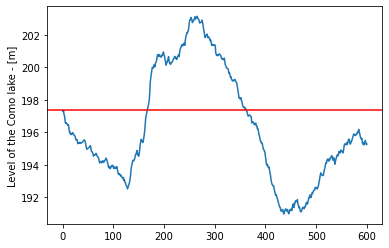

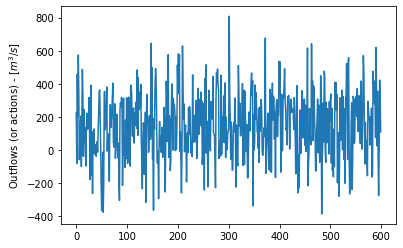

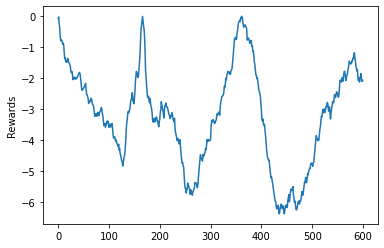

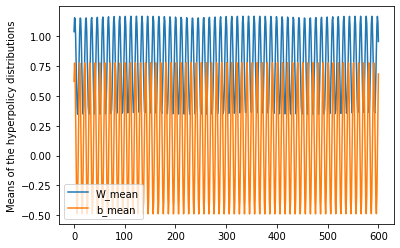

In [6]:
# Get random hyperpolicy
nu = hyperpolicy()

# Initialize the Como lake environment
lake = como_lake()

# Play the hyperpolnuicy
states, actions, rewards, nu_means, thetas = lake.play(nu, n_steps=600, optimize=False)

# Plot the evolution of everything
plt.plot(states)
plt.axhline(y=197.37, c='red', label="Zero Level")
plt.ylabel("Level of the Como lake - [m]")
plt.show()

plt.plot(actions)
plt.ylabel("Outflows (or actions) - [$m^3/s$]")
plt.show()

plt.plot(rewards)
plt.ylabel("Rewards")
plt.show()

plt.plot(nu_means[:,0], label="W_mean")
plt.plot(nu_means[:,1], label="b_mean")
plt.ylabel("Means of the hyperpolicy distributions")
plt.legend()
plt.show()

In [7]:
# Test the three performance estimators with alpha=400
alpha = 400
performances = np.array([]).reshape(0,3)

# Estimators works only after alpha timesteps and take into account also
# the rewards at time t, thus the right limit for the interval is t+1
for t in tnrange(alpha,len(rewards)):
    J1 = pe.Trajectory_Return(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t)
    J2 = pe.PerStep_Reward_prod(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t)    
    J3 = pe.PerStep_Reward(nu, thetas[t-alpha:t+1], rewards[t-alpha:t+1], t)  
    performances = np.append(performances, [[J1,J2,J3]], axis = 0)

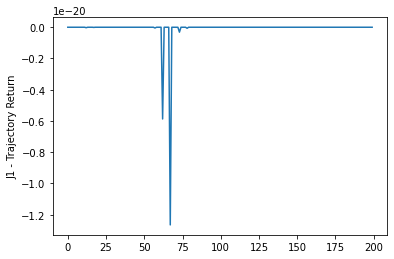

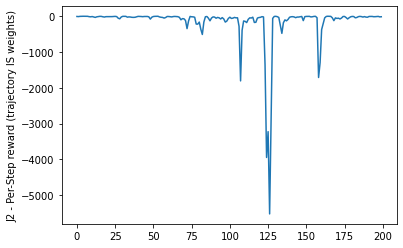

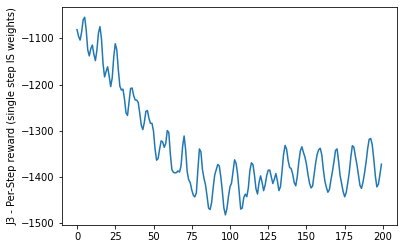

In [8]:
# Plot the estimated performances as functions of time
plt.plot(performances[:,0])
plt.ylabel("J1 - Trajectory Return")
plt.show()

plt.plot(performances[:,1])
plt.ylabel("J2 - Per-Step reward (trajectory IS weights)")
plt.show()

plt.plot(performances[:,2])
plt.ylabel("J3 - Per-Step reward (single step IS weights)")
plt.show()

In [9]:
performances

array([[-1.34471915e-59, -7.05611082e+00, -1.08128103e+03],
       [-2.81379098e-41, -1.03435705e+01, -1.09589173e+03],
       [-5.87058794e-26, -4.05249673e+00, -1.10383662e+03],
       [-3.54575215e-34, -1.88283636e+00, -1.08663611e+03],
       [-5.00349332e-57, -1.10834182e+00, -1.06025020e+03],
       [-2.35482733e-63, -2.60336240e+00, -1.05444778e+03],
       [-9.61878315e-45, -2.45291396e+00, -1.08249265e+03],
       [-1.89026412e-26, -2.48680975e+00, -1.12524111e+03],
       [-9.47700871e-35, -1.23143048e+01, -1.13806195e+03],
       [-2.43289199e-60, -1.60341512e+01, -1.12242855e+03],
       [-2.44795171e-69, -9.29964236e+00, -1.11454932e+03],
       [-8.01616411e-48, -2.19260151e+01, -1.13441623e+03],
       [-2.84196063e-23, -3.31912349e+01, -1.14832417e+03],
       [-2.59651065e-27, -1.65644286e+01, -1.12518510e+03],
       [-2.65754288e-54, -1.03949897e+01, -1.08861776e+03],
       [-2.13149011e-68, -3.46112324e+00, -1.07477428e+03],
       [-5.19796843e-50, -4.97539919e+00